In [11]:
#%%timeit -n1 -r1

In [143]:
import os
import albumentations
import cv2

import gc as Garbase_Collector
import numpy as np
import pandas as pd
import tensorflow as tf

In [144]:
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models

In [209]:
df1 = pd.read_csv('./Data_Entry_2017.csv')
img_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df1['img_path'] = df['Image Index'].map(img_paths.get)
df1.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],img_path
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,.\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,.\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,.\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,.\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,.\images\00000003_000.png


In [215]:
df2 = df1[['Finding Labels', 'Patient ID', 'img_path']]
df2.head()

,Finding Labels,Patient ID,img_path
0,Cardiomegaly,1,.\images\00000001_000.png
1,Cardiomegaly|Emphysema,1,.\images\00000001_001.png
2,Cardiomegaly|Effusion,1,.\images\00000001_002.png
3,No Finding,2,.\images\00000002_000.png
4,Hernia,3,.\images\00000003_000.png


In [217]:
labels=df2['Finding Labels'].str.split('|',expand=True).stack().unique()
for l in labels:
    df2[l]=df2['Finding Labels'].map(lambda x:1 if l in x else 0)

C:\Users\m7irt\AppData\Local\Temp\ipykernel_20248\1743994582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[l]=df2['Finding Labels'].map(lambda x:1 if l in x else 0)
C:\Users\m7irt\AppData\Local\Temp\ipykernel_20248\1743994582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[l]=df2['Finding Labels'].map(lambda x:1 if l in x else 0)
C:\Users\m7irt\AppData\Local\Temp\ipykernel_20248\1743994582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [219]:
df2.sample(100)

,Finding Labels,Patient ID,img_path,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
64041,Pneumonia,15806,.\images\00015806_003.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
81205,Infiltration,19940,.\images\00019940_000.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
26060,No Finding,6849,.\images\00006849_001.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
89631,Fibrosis,22253,.\images\00022253_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16260,Cardiomegaly|Edema|Effusion|Pneumonia,4342,.\images\00004342_054.png,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62042,No Finding,15355,.\images\00015355_004.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
60657,No Finding,14971,.\images\00014971_004.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62959,Infiltration|Nodule,15563,.\images\00015563_008.png,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
62012,No Finding,15344,.\images\00015344_002.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


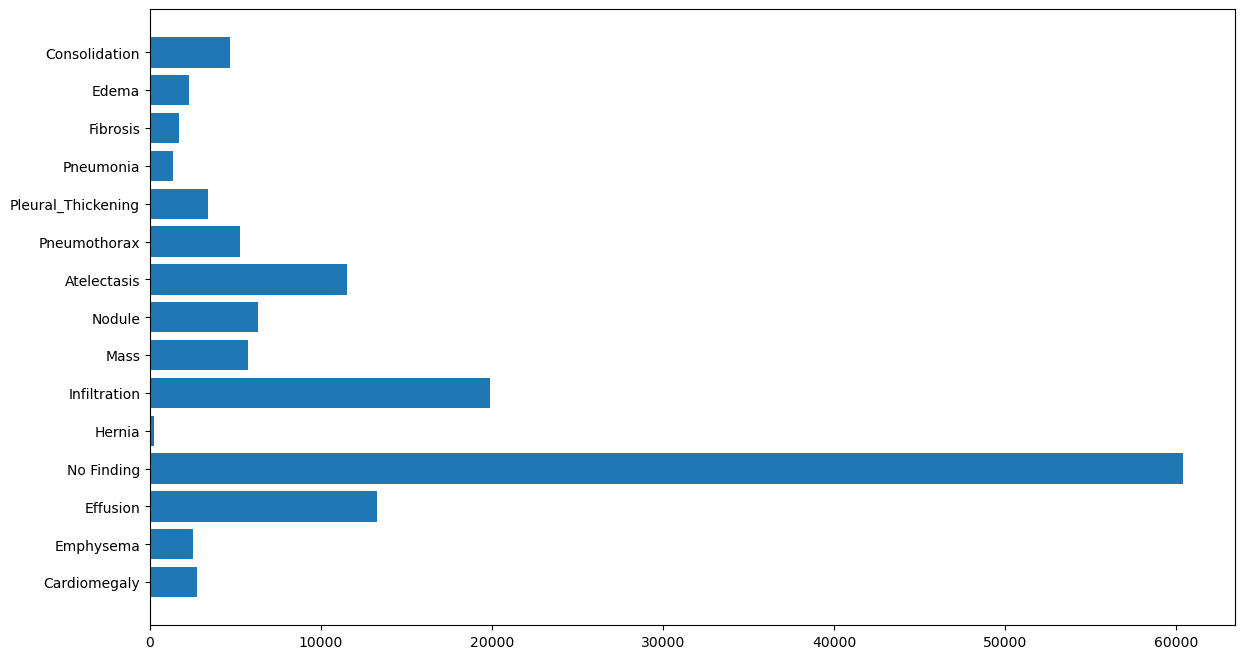

In [220]:
a=df2.drop(columns=['Patient ID','img_path','Finding Labels']).sum().values
b=df2.drop(columns=['Patient ID','img_path','Finding Labels']).sum().index
plt.subplots(figsize=(14,8))
plt.barh(b,a)
plt.show()

In [223]:
df2.drop(columns=['Patient ID','img_path','Finding Labels']).sum()/len(df2)

Cardiomegaly          0.024724
Emphysema             0.022440
Effusion              0.118685
No Finding            0.538816
Hernia                0.002025
Infiltration          0.177221
Mass                  0.051249
Nodule                0.056395
Atelectasis           0.102881
Pneumothorax          0.047253
Pleural_Thickening    0.030191
Pneumonia             0.012067
Fibrosis              0.015037
Edema                 0.020540
Consolidation         0.041625
dtype: float64

In [224]:
df2.to_csv('image_path_with_labels.csv')

In [156]:
dataset_info = pd.read_csv('.\\meta_data.csv')

df_train, df_test = train_test_split(dataset_info, test_size = 0.20, random_state = 42)
# df_train, df_test = train_test_split(dataset_info.sample(n = 50000), test_size = 0.20, random_state = 42)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 42)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [157]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
CLASS_LABELS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis", 
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"
]

In [193]:
def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image_Path", 
        y_col = "Image_Labels_List",
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'categorical',
#         classes = CLASS_LABELS,
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

In [194]:
from keras_preprocessing.image import ImageDataGenerator

base_generator = ImageDataGenerator(rescale = 1. / 255)

train_gen = flow_from_dataframe(
    image_generator = base_generator,
    dataframe = df_train
)

valid_gen = flow_from_dataframe(
    image_generator = base_generator,
    dataframe = df_val    
)

test_gen = flow_from_dataframe(
    image_generator = base_generator,
    dataframe = df_test
)

Found 80726 validated image filenames belonging to 707 classes.
Found 8970 validated image filenames belonging to 293 classes.
Found 22424 validated image filenames belonging to 412 classes.


In [195]:
train_x, train_y = train_gen.next()

print(f"Dimension of Image # 1: {train_x[0].shape}")
for i in range(10): print(f"Label of Image # {i}: {train_y[i]}")
print(f"Type of Labels of Image # 1: {len(train_y[0])} and {train_y[0]}")

Dimension of Image # 1: (224, 224, 3)
Label of Image # 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [177]:
from keras.layers import Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers.core import Dense
from keras.models import Model

input_shape = (224, 224, 3)
img_input = Input(shape = input_shape)

base_model = ResNet50V2(
    include_top = False, 
    input_tensor = img_input, 
    input_shape = input_shape, 
    pooling = "avg", 
    weights = 'imagenet'
)

x = base_model.output
predictions = Dense(15, activation = "sigmoid", name = "predictions")(x)
model = Model(inputs = img_input, outputs = predictions)

In [69]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [178]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import shutil
import warnings
import json

class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Calcula el promedio de las Curvas ROC y guarda el mejor grupo de pesos
        de acuerdo a esta metrica
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#ejemplos, len(etiquetas))
        y: [(#ejemplos, 1), (#ejemplos, 1) ... (#ejemplos, 1)]
        """
        y_hat = self.model.predict_generator(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels

        print(f"*** epoch#{epoch + 1} Curvas ROC Fase Entrenamiento ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Promedio Curvas ROC: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Actualización del resultado de las Curvas de ROC de: {self.stats['best_mean_auroc']} a {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Actualización del archivo de logs: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Actualización del grupo de pesos: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

In [179]:
from keras.callbacks import ModelCheckpoint

model_train = model
output_weights_name='weights.h5'

checkpoint = ModelCheckpoint(
    output_weights_name,
    save_weights_only=True,
    save_best_only=True,
    verbose=1,
)

In [180]:
training_stats = {}

auroc = MultipleClassAUROC(
    generator = valid_gen,
    class_names = CLASS_LABELS,
    weights_path = output_weights_name,
    stats = training_stats
)

In [181]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

initial_learning_rate = 1e-3
optimizer = Adam(learning_rate = initial_learning_rate)
model_train.compile(
    optimizer = optimizer, 
    loss = "binary_crossentropy", 
    metrics = ['acc', tf.keras.metrics.FalseNegatives()]
)

In [184]:
from keras.callbacks import TensorBoard, ReduceLROnPlateau

patience_reduce_lr = 2
min_lr = 1e-8
callbacks = [
    checkpoint,
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.1, 
        patience = patience_reduce_lr, 
        verbose = 1, 
        mode = "min", 
        min_lr = min_lr
    ),
    auroc,
]

In [185]:
history = model.fit(
    x = train_x,
    y = train_y,
#     batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose = "auto",
    callbacks = callbacks,
    validation_split = 0.0,
    validation_data = valid_gen,
    shuffle = True,
#     class_weight = None,
#     sample_weight = None,
    initial_epoch=0,
    steps_per_epoch = None,
    validation_steps = None,
    validation_batch_size = BATCH_SIZE,
#     validation_freq = 1,
#     max_queue_size = 10,
    workers = 1,
    use_multiprocessing = True,
)

Epoch 1/10


ValueError: in user code:

    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((32, 15) vs (32, 1))


In [186]:
fit_history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    epochs = EPOCHS,
    validation_data = valid_gen,
    validation_steps = valid_gen.n / valid_gen.batch_size,
    callbacks = callbacks,
    shuffle = False
)

C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


ValueError: in user code:

    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 15) vs (None, 1))


In [22]:
np.warnings.filterwarnings('ignore', category = np.VisibleDeprecationWarning)

def get_data(df, img_size):
    data = []
    
    paths = df.Image_Path.values
    labels = df.Binary_Image_Labels.values
    
    for path, label in tqdm(zip(paths, labels), desc = "Progress"):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        data.append([img, label])
        
    return np.array(data, dtype = object)

In [17]:
train_data = get_data(df_train, IMAGE_SIZE)
del df_train
val_data = get_data(df_val, IMAGE_SIZE)
del df_val
test_data = get_data(df_test, IMAGE_SIZE)
del df_test

Progress: 36000it [09:52, 60.73it/s]
Progress: 4000it [01:11, 55.90it/s]
Progress: 10000it [02:43, 61.26it/s]


In [18]:
x_train, y_train, x_val, y_val = [], [], [], []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

del train_data

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

del val_data

In [19]:
Garbase_Collector.collect()

225

In [20]:
# Normalize the data
img_size = IMAGE_SIZE[0]
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)

x_val = np.array(x_val) / 255
x_val.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_val = np.array(y_val)

In [21]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False  # randomly flip images
)

data_generator.fit(x_train)

MemoryError: Unable to allocate 6.59 GiB for an array with shape (36000, 128, 128, 3) and data type float32

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobile_net_v2 = MobileNetV2(input_shape =  (128, 128, 3), include_top = False, weights = "imagenet")

model = Sequential()
model.add(mobile_net_v2)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(15, activation = 'sigmoid'))

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy',
    metrics = [
        'accuracy', 
        'binary_accuracy', 
        'mae', 
#         precision_threshold(threshold = 0.5), 
#         recall_threshold(threshold = 0.5), 
#         fbeta_score_threshold(beta=0.5, threshold = 0.5)
    ]
)

model.summary()

In [ ]:
history = model.fit(x_train,y_train, epochs = 10 , validation_data = (x_val, y_val))

In [ ]:
# opt = Adam(lr=0.000001)
# model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
# history = model.fit_generator(x_train,steps_per_epoch = 100, validation_data = (x_val,y_val), epochs = 10)